## This notebook demonstrates how to correctly load and visualize the preprocessed sway data.
```
Dataset hierarchy is managed as follows:
data/sway61769/dataset61769.txt                                 ----> a list of all the video folder names
              /sway61769/video_folder_1/images/{frame:05}.jpg   ----> all image files
                                       /intrinsics.npy
                                       /extrinsics.npy
                                       /bbox.npy
                                       /wspace_poses3d.npy      ----> w-space 3d poses that are consistent with h36m coordinates
                                       /cspace-poses3d.npy      ----> c-space 3d poses that are consistent with h36m coordinates "in root-relative space"
                                       /keypts2d.json
              /sway61769/video_folder_2
              /sway61769/video_folder_3
              /sway61769/video_folder_4
```

In [1]:
import os
import json
#import torch
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from numpy.linalg import inv

In [2]:
### IMPORTANT!!! Joint order information
n_joints = 22
smpljoint_order = ["hips",
                   "left_hip",
                   "right_hip",
                   "spine",
                   "left_knee",
                   "right_knee",
                   "spine1",
                   "left_ankle",
                   "right_ankle",
                   "spine2",
                   "left_toe_base",
                   "right_toe_base",
                   "neck",
                   "left_shoulder",
                   "right_shoulder",
                   "head",
                   "left_upperarm",
                   "right_upperarm",
                   "left_elbow",
                   "right_elbow",
                   "left_wrist",
                   "right_wrist",
                   ]

### These are the joints I used to match the joint order of the h36m prediction output in my IK visualizer. You might need further confirmation when loading them to METRO
# hip, head, r_upperarm, r_elbow, r_wrist, l_upperarm, l_elbow, l_wrist
smpl_7joints_indices = [0, 15, 17, 19, 21, 16, 18, 20]


### 2D keypoint order. It follows openpose format. You might need it later for 2Ddataset
kpt2d_order = ["nose",
               "neck",
               "r_shoulder",
               "r_elbow",
               "r_hand",
               "l_shoulder",
               "l_elbow",
               "l_hand",
               "pelvis",
               "r_hips",
               "r_knee",
               "r_ankle",
               "l_hips",
               "l_knee",
               "l_ankle",
               "r_eye",
               "l_eye",
               "r_ear",
               "l_ear",
               "l_toe",
               "l_toe_end",
               "l_ankle_end",
               "r_toe",
               "r_toe_end",
               "r_ankle_end",
               ]

In [3]:
sway_folder = "/home/jovyan/data/metrabs-processed/sway"
root = f"{sway_folder}/sway61769"

### Get all video folder names. Don't us os.listdir(root) because it is too slow
with open(f"{sway_folder}/dataset61769.txt", "r") as f:
    vidnames = [line.strip() for line in f.readlines()]

In [4]:
len(vidnames)

61735

In [5]:
### Load all annotations from a video folder

def load_all_annotations_from_folder(folderpath):
    kptpath = os.path.join(folderpath, "keypts2d.json")
    world3dpath = os.path.join(folderpath, "wspace_poses3d.npy")
    cam3dpath = os.path.join(folderpath, "cspace-poses3d.npy")
    camextpath = os.path.join(folderpath, "extrinsics.npy")
    camintpath = os.path.join(folderpath, "intrinsics.npy")
    bboxpath = os.path.join(folderpath, "bbox.npy")
    
    ## W-space 3D Poses
    world_pose3d = np.load(world3dpath)
    
    ## C-space 3D Poses
    cam_pose3d = np.load(cam3dpath)
    
    ## Camera intrinsics and extrinsics
    intrinsics = np.load(camintpath)
    extrinsics = np.load(camextpath)
    
    ## Bounding boxes
    bbox = np.load(bboxpath)
    
    ## 2D keypoints
    with open(kptpath, "r") as f:
        kpt_params = json.load(f)
    keypoints = kpt_params["key_points"]

    return world_pose3d, cam_pose3d, intrinsics, extrinsics, bbox, keypoints


In [6]:
### Randomly choose a video and do camera projection to visualize its overlay with image.
# np.random.seed(12)
vidname = np.random.choice(vidnames)
folderpath = os.path.join(root, vidname)
print(vidname)
world_pose3d, cam_pose3d, intrinsics, extrinsics, bbox, keypoints = load_all_annotations_from_folder(folderpath)

122eba05-eb93-47c8-bb11-a18eed125952


In [16]:
# print("W-space pose (#fr,22,3):", world_pose3d.shape, " C-space pose (#fr,22,3):", cam_pose3d.shape, 
#       " Intrinsics (3,3):", intrinsics.shape, " Extrinsics (4,4):", extrinsics.shape, 
#       " Bbox (#fr,4):", bbox.shape)
# print("\nPreview keypoint data:\n", keypoints['0']) 
# print("\nLength of 2D keypoints:", len(keypoints))
# print(f"intrinsics: {intrinsics}\nextrinsics: {extrinsics}\nworld_pose3d: {world_pose3d[0]}")
# ### Keypoints are represented in relative ratio
# ### Bounding boxes are represented in (x, y, w, h)

In [8]:
### Camera projection from world space 3d poses

# Pad 1 to make pose a 4d vector: (L, J, 3) --> (L, J, 4)
world_pose4d = np.concatenate((world_pose3d, np.ones([world_pose3d.shape[0], world_pose3d.shape[1], 1])), axis=-1)

# World to camera coordinate: (4, 4) x (L, J, 4) --> (L, J, 4)
cam_pose4d = np.tensordot(extrinsics, world_pose4d, axes=([1], [2])).transpose(1, 2, 0)
recalculated_cam_pose3d = cam_pose4d[..., :3] # (L, J, 3)
print("diff:", np.max(np.abs(cam_pose3d - recalculated_cam_pose3d))) ### The same as the saved cspace 3d pose
        
## homogeneous coordinates: (L, J, 3)
cam_pose3d_homo = cam_pose3d / cam_pose3d[..., -1:]

## project to image space: (2, 3) x (L, J, 3) --> (L, J, 2)
joint2d_proj = np.tensordot(intrinsics[:2], cam_pose3d_homo, axes=([1], [2])).transpose(1, 2, 0)

diff: 0.0


In [9]:
### Obtain all image filenames
imagefiles = [f for f in sorted(os.listdir(os.path.join(root, vidname, "images"))) if f.endswith(".jpg")]

########## IMPORTANT!!! Note that image files may be 1~2 frames longer than pose sequences. Always use the length of pose sequence as reference


In [10]:
def overlay_visualization(imagepath, keypoint_2d, projected_2d, bbox):
    image = imread(imagepath)
    h, w, _ = image.shape
    plt.imshow(image)
    
    ### Show the reprojected keypoints
    for j in range(projected_2d.shape[0]):
        plt.plot(projected_2d[j, 0], projected_2d[j, 1], "o", markersize=7, color="orange")
        
    ### Show the keypoints
    for joint2d in keypoint_2d:
        x = joint2d['u'] * w
        y = joint2d['v'] * h
        plt.plot(x, y, "o", markersize=3, color="white", alpha=joint2d['confidence'])
    min_x = bbox[0]
    min_y = bbox[1]
    max_x = bbox[0] + bbox[2]
    max_y = bbox[1] + bbox[3]
    plt.plot([min_x, max_x, max_x, min_x, min_x], [min_y, min_y, max_y, max_y, min_y])
    plt.show() 
    return

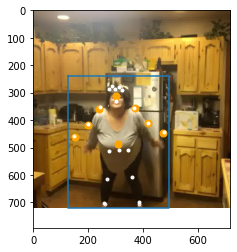

In [11]:
n_frames = world_pose3d.shape[0]
frame_index = np.random.randint(0, n_frames)

imagepath = os.path.join(root, vidname, "images", imagefiles[frame_index])

overlay_visualization(imagepath, keypoints[str(frame_index)], joint2d_proj[frame_index, smpl_7joints_indices], bbox[frame_index])

In [12]:
### Note that 2d keypoints and overlaid poses may be out of image frames because they are estimated. However, bbox would always be within image boundary.

In [13]:
deg = 5
views = [(deg, deg - 90), (deg, deg), (90 - deg, deg - 90)]
def plot_skeleton(axis, p, color='r'):
    axis.scatter(p[:, 0], p[:, 1], p[:, 2], s=1, c=color)

    skeleton = [(9, 8), (8, 7), (7, 10), (10, 11), (11, 12),
            (7, 13), (13, 14), (14, 15), (7, 6), (6, 16), 
            (16, 3), (3, 4), (4, 5), (16, 0), (0, 1), (1, 2)]  # head

    for i, j in skeleton:
        plt.plot([p[i, 0], p[j, 0]], [p[i, 1], p[j, 1]], [p[i, 2], p[j, 2]], color)
        
def upper_plot_skeleton(axis, p, color='r'):
    axis.scatter(p[:, 0], p[:, 1], p[:, 2], s=1, c=color)

    skeleton = [(1, 2), (2, 3), (4, 5), (5, 6), (1,4)]  # head
    axis.scatter(p[:, 0], p[:, 1], p[:, 2], s=1, c=color, alpha=1.0 )

    for i, j in skeleton:
        plt.plot([p[i, 0], p[j, 0]], [p[i, 1], p[j, 1]], [p[i, 2], p[j, 2]], color)            

    center_shoulder = (p[1,:] + p[4,:])/2.0     
    plt.plot([center_shoulder[0], p[0, 0]], [center_shoulder[1], p[0, 1]], [center_shoulder[2], p[0, 2]], color)            
    plt.plot([center_shoulder[0], p[7, 0]], [center_shoulder[1], p[7, 1]], [center_shoulder[2], p[7, 2]], color)  

    




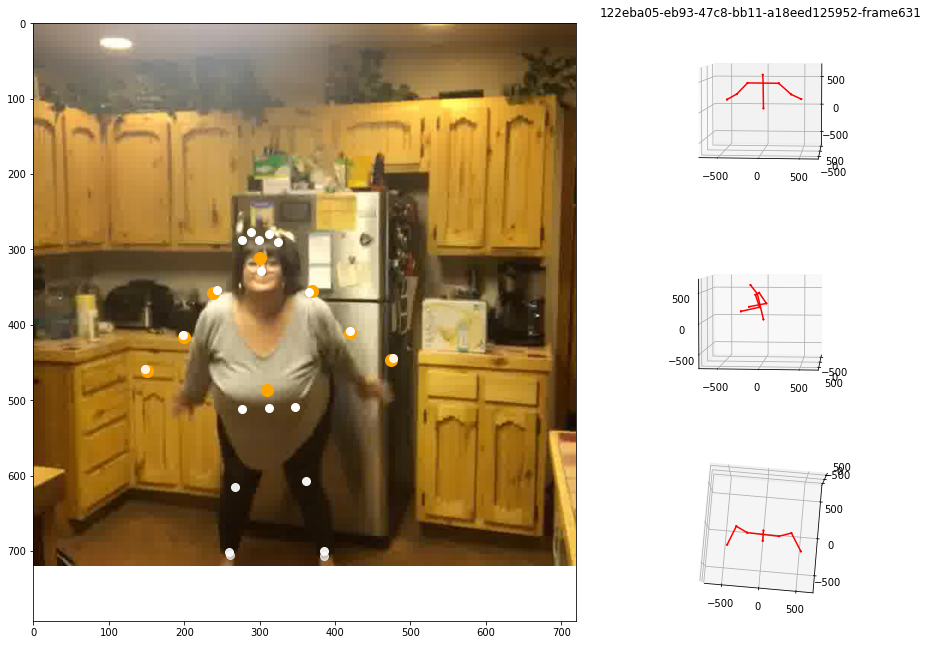

In [14]:
img = imread(imagepath)

i_relevant_joints = [2, 5, 8, 1, 4, 7, 9, 12, 15, 15, 16, 18, 20, 17, 19, 21, 0]
world_coords = world_pose3d[:, i_relevant_joints]
world_coords -= world_coords[:, -1, np.newaxis]

fig = plt.figure(figsize=(2 * 1 + 2 + 26, 2 * len(views) + 5))

for i_v in range(len(views)):
    ax = fig.add_subplot(len(views), 2, 2*i_v + 2, projection='3d')
    ax.view_init(*views[i_v])
#     plot_skeleton(ax, world_coords[frame_index], 'b')
    upper_plot_skeleton(ax, world_coords[frame_index, -8:], 'r')

    #ax.set_xlabel('x')
    ax.set_xlim3d(-700, 700)
    ax.set_zlim3d(-700, 700)
    ax.set_ylim3d(-700, 700)
    if i_v == 0:
        ax.set_title(f"{vidname}-frame{frame_index}")

ax2 = fig.add_subplot(1, 1, 1)
ax2.imshow(img)

### Show the reprojected keypoints
projected_2d = joint2d_proj[frame_index, smpl_7joints_indices]
for j in range(projected_2d.shape[0]):
    ax2.plot(projected_2d[j, 0], projected_2d[j, 1], "o", markersize=12, color="orange")

### Show the keypoints
for joint2d in keypoints[str(frame_index)]:
    x = joint2d['u'] * img.shape[1]
    y = joint2d['v'] * img.shape[0]
    ax2.plot(x, y, "o", markersize=8, color="white", alpha=joint2d['confidence'])
